In [184]:
import json
from PIL import Image, ImageDraw, ImageFont, ImageOps
import requests
import os
from io import BytesIO
import requests
from IPython.display import display

#### Load dataset

In [185]:
## load dataset
with open('test.story-in-sequence.json', 'r') as f:
    data = json.load(f)

In [186]:
## this contains information on all images which can be used to retrived images from URL
images = data['images'] 

## this contains information on all story seequence
stories = data['annotations']

In [187]:
images

[{'datetaken': '2004-11-27 10:40:46',
  'license': '1',
  'title': 'The venue.',
  'text': '',
  'album_id': '44277',
  'longitude': '-0.212688',
  'url_o': 'https://farm1.staticflickr.com/2/1741642_81837e8e9e_o.jpg',
  'secret': '81837e8e9e',
  'media': 'photo',
  'latitude': '51.920449',
  'id': '1741642',
  'tags': 'stevenage fairies craftfair xmas 2004'},
 {'datetaken': '2004-11-27 11:09:51',
  'license': '1',
  'title': 'Mobbed.',
  'text': '',
  'album_id': '44277',
  'longitude': '-0.212688',
  'url_o': 'https://farm1.staticflickr.com/2/1741640_2a4e2ee734_o.jpg',
  'secret': '2a4e2ee734',
  'media': 'photo',
  'latitude': '51.920449',
  'id': '1741640',
  'tags': 'stevenage fairies craftfair xmas 2004'},
 {'datetaken': '2004-11-27 11:10:11',
  'license': '1',
  'title': 'The excitement is building.',
  'text': '',
  'album_id': '44277',
  'longitude': '-0.212688',
  'url_o': 'https://farm1.staticflickr.com/2/1741639_fbc2df1afa_o.jpg',
  'secret': 'fbc2df1afa',
  'media': 'photo'

In [188]:
stories

[[{'original_text': 'The local parish holds a craft show each year.',
   'album_id': '44277',
   'photo_flickr_id': '1741642',
   'setting': 'first-2-pick-and-tell',
   'worker_id': 'FJROI8NWDRIPAM1',
   'story_id': '45530',
   'tier': 'story-in-sequence',
   'worker_arranged_photo_order': 0,
   'text': 'the local parish holds a craft show each year .',
   'storylet_id': '227650'}],
 [{'original_text': 'Lots of folks come out and set up tables to sell their crafts.',
   'album_id': '44277',
   'photo_flickr_id': '1741640',
   'setting': 'first-2-pick-and-tell',
   'worker_id': 'FJROI8NWDRIPAM1',
   'story_id': '45530',
   'tier': 'story-in-sequence',
   'worker_arranged_photo_order': 1,
   'text': 'lots of folks come out and set up tables to sell their crafts .',
   'storylet_id': '227651'}],
 [{'original_text': 'Some of these crafts are very unique and take a lot of talent to make.',
   'album_id': '44277',
   'photo_flickr_id': '1741632',
   'setting': 'first-2-pick-and-tell',
   'wo

#### Stories can be clustered using the 'story_id' key, so first we get all the story ids:

In [189]:
story_ids = list(set([story[0]['story_id'] for story in stories]))
print(f"There are {len(story_ids)} stories")
assert len(stories)==len(story_ids)*5

There are 5055 stories


In [190]:
album_ids = list(set([story[0]['album_id'] for story in stories]))
print(f"There are {len(album_ids)} albums")

There are 1011 albums


In [191]:
## create a dict containing mapping from story_id to album_id
story_album_dict = {i[0]['story_id']:i[0]['album_id'] for i in stories}
story_album_dict

{'45530': '44277',
 '45531': '44277',
 '45532': '44277',
 '45533': '44277',
 '45534': '44277',
 '45535': '8139',
 '45536': '8139',
 '45537': '8139',
 '45538': '8139',
 '45539': '8139',
 '45540': '504823',
 '45541': '504823',
 '45542': '504823',
 '45543': '504823',
 '45544': '504823',
 '45545': '72157607155047588',
 '45546': '72157607155047588',
 '45547': '72157607155047588',
 '45548': '72157607155047588',
 '45549': '72157607155047588',
 '45550': '72157605016116512',
 '45551': '72157605016116512',
 '45552': '72157605016116512',
 '45553': '72157605016116512',
 '45554': '72157605016116512',
 '45555': '72157644777317969',
 '45556': '72157644777317969',
 '45557': '72157644777317969',
 '45558': '72157644777317969',
 '45559': '72157644777317969',
 '45560': '72157605629519358',
 '45561': '72157605629519358',
 '45562': '72157605629519358',
 '45563': '72157605629519358',
 '45564': '72157605629519358',
 '45565': '72157605630785895',
 '45566': '72157605630785895',
 '45567': '72157605630785895',
 '

#### Let's check one story sequence to see if it makes sense:

In [202]:
sample_story_id = story_ids[3]
print(f"We take a look at story {sample_story_id}:")

We take a look at story 46155:


In [203]:
## Funtion to retrieve story with a story id
def get_story_images(story_id:str, images:list, stories:list, story_album_dict:dict):
    story = [s for s in stories if s[0]['story_id']==story_id]
    story_images = [i for i in images if i['album_id']==story_album_dict[story_id]]
#     image_ids = [s['photo_flickr_id'] for s in story]
#     image_urls = [i['url_o'] for i in images if i['id'] in image_ids]
    story_list = [(s[0],img) for s in story for img in story_images if img['id']==s[0]['photo_flickr_id']]
    return story_list

In [204]:
## Function to retrieve image from URL
def get_image_from_url(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    img = img.convert('RGB')
    return img

In [205]:
## Function to display story
def display_story(story_list:list):
    for s in story_list:
        #display image
        img = get_image_from_url(s[1]['url_o'])
        display(img)
        
        #print label
        print(s[0]['original_text'])

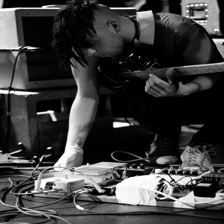

It was time for practice, and he wondered how they always managed to tangle the wires.


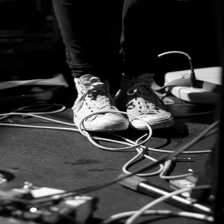

It would be easy to trip over the wires, and even just standing there, he could see that.


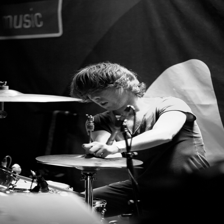

He adjusted the cymbals, wondering if the session would be successful.


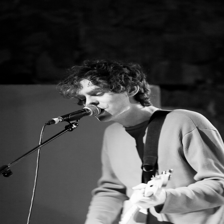

He began with one of the softer songs, loosening up his vocal cords.


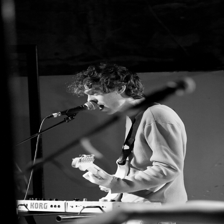

As his voice warmed up, he tested some louder notes, thinking this recording session would work out fine.


In [206]:
story_list = get_story_images(sample_story_id, images, stories, story_album_dict)
display_story(story_list)

This story seems ok !